In [2]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import zipfile
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets

torch.cuda.set_device(7)

In [3]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

In [4]:
def extract_and_split(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        overall_train_data = []
        overall_test_data = []
        y_train = []
        y_test = []
        subfolders = {os.path.dirname(name) for name in zip_ref.namelist()}
        
        for subfolder in subfolders:
            if subfolder in ['dataset', 'dataset/z', 'dataset/y'] :
                continue
            files_in_subfolder = [name for name in zip_ref.namelist() if name.startswith(subfolder) and not name.endswith('.directory')]
            class_name = subfolder.split('/')[-1]
            train_files, test_files = train_test_split(files_in_subfolder, train_size=0.8)
            overall_train_data += train_files
            overall_test_data += test_files
            y_train += [class_name] * len(train_files)
            y_test += [class_name] * len(test_files)

        return overall_train_data, overall_test_data, y_train, y_test

In [5]:
x_train, x_test, y_train, y_test = extract_and_split('./MoreSymbol.zip')

FileNotFoundError: [Errno 2] No such file or directory: './data/MoreSymbol.zip'

In [4]:
# Combine and find unique classes
all_classes = np.unique(y_train)

# Create a mapping dictionary
mapping = {class_name.item(): idx for idx, class_name in enumerate(all_classes)}

# Apply the mapping
y_train = torch.tensor([mapping[class_name] for class_name in y_train])
y_test = torch.tensor([mapping[class_name] for class_name in y_test])

In [5]:
perm = np.random.permutation(range(len(x_train)))
x_train = np.array(x_train)[perm]
y_train = np.array(y_train)[perm] 

In [6]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# from tensorflow.keras import Input, Model

2024-01-30 21:53:00.303908: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 21:53:00.358725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, labels, transforms, zipfile):
        super(MyDataset, self).__init__()
        self.img_list = img_list
        self.labels = labels
        self.transforms = transforms
        self.zipfile = zipfile

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        img = Image.open(self.zipfile.open(img)).convert('L')
        return self.transforms(img), self.labels[idx]

In [8]:
imgzip = zipfile.ZipFile("/home/liuy29/Image Rec/data/MoreSymbol.zip")
img_path = x_train[456]
image = Image.open(imgzip.open(img_path))
image.size

(155, 135)

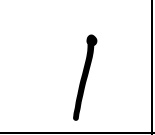

In [9]:
image

In [23]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# train_dataset = MyDataset(x_train, y_train, transform, imgzip)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataset = MyDataset(x_test, y_test, transform, imgzip)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 96493143.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50854615.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28298006.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 31645396.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [24]:
# num_classes = len(np.unique(y_train))
num_classes = 10

In [25]:


input_channels = 1
conv_layers = nn.Sequential(
    nn.Conv2d(input_channels, 16, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU()
)

# Calculate the size of the output of the conv_layers by doing one forward pass
dummy_input = torch.randn(1, input_channels, 100, 100)
output = conv_layers(dummy_input)
conv_out = output.shape[1] * output.shape[2] * output.shape[3]

model = nn.Sequential(
    conv_layers,
    nn.Flatten(),
    nn.Linear(conv_out, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, num_classes)
)

In [26]:
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    # Training Phase
    model.train()
    total_train_loss = 0
    for inputs, labels in train_loader:
        #print('labels', labels)
        inputs, labels = inputs.to(device), torch.tensor(labels).to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation Phase
    # model.eval()
    # total_valid_loss = 0
    # with torch.no_grad():
    #     for inputs, labels in valid_loader:
    #         inputs, labels = inputs.to(device), labels.to(device)

    #         # Forward pass
    #         outputs = model(inputs)
    #         loss = loss_fn(outputs, labels)

    #         total_valid_loss += loss.item()

    # avg_valid_loss = total_valid_loss / len(valid_loader)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}')

/tmp/ipykernel_1503724/1773056581.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)


Epoch [1/10], Train Loss: 4.0793
Epoch [2/10], Train Loss: 2.3023
Epoch [3/10], Train Loss: 2.3022
Epoch [4/10], Train Loss: 2.3020


In [19]:
model.eval()

total_loss = 0
total_correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.tensor(labels).to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        # Convert outputs probabilities to predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Calculate correct predictions
        total_correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(test_loader)
accuracy = total_correct / len(test_loader.dataset)

print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

/tmp/ipykernel_1503724/1784268762.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)


Test Loss: 2.8268, Test Accuracy: 0.0689
